In [1]:
## Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set(palette='icefire')

## Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing, metrics
import xgboost

from collections import Counter
import statistics as stat
import hashlib ## for converting strings into unique ints
import _functions_1115 as func

In [2]:
data = func.makeready(pd.read_csv('./data/Final_Movie_Data_Cleaned.csv'))

/home/jr/Documents/GitHub/miniproject_1115/Movies/_functions_1115.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in.dropna(axis=0, subset=['producer_0',], inplace=True)
/home/jr/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [3]:
data_raw=pd.read_csv('./data/Final_Movie_Data_Cleaned.csv')
data_raw.convert_dtypes().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              1836 non-null   Int64  
 1   tmdb_id                 1836 non-null   Int64  
 2   imdb_id                 1836 non-null   string 
 3   year_film               1836 non-null   Int64  
 4   year_ceremony           1836 non-null   Int64  
 5   film                    1836 non-null   string 
 6   oscar_category          1836 non-null   string 
 7   nominee                 1836 non-null   string 
 8   oscar_win               1836 non-null   boolean
 9   no_oscar_wins           1836 non-null   Int64  
 10  no_oscar_nominations    1836 non-null   Int64  
 11  staring_casts           1836 non-null   string 
 12  casts_popularity        1836 non-null   float64
 13  director                1836 non-null   string 
 14  producers               1836 non-null   

In [4]:
## removing the last header that is not required for ML
data_ml = data.drop('film', axis=1)
## hashing all string columns into ints
fields = data_ml.select_dtypes('object').columns.tolist()
for field in fields:
    data_ml[field] = data_ml[field].apply(lambda x: int(hashlib.sha256(x.encode('utf-8')).hexdigest(),16) % 10**8)

In [5]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1776 entries, 1 to 1835
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   oscar_cat          1776 non-null   int64  
 1   oscar_win          1776 non-null   bool   
 2   oscar_nominations  1776 non-null   int64  
 3   total_wins         1776 non-null   int64  
 4   total_nominations  1776 non-null   int64  
 5   cast_popularity    1776 non-null   float64
 6   crew_popularity    1776 non-null   float64
 7   tmdb_vote_average  1776 non-null   int64  
 8   tmdb_vote_count    1776 non-null   int64  
 9   imdb_rating        1776 non-null   int64  
 10  imdb_votes         1776 non-null   int64  
 11  rotten_tomatoes    1776 non-null   float64
 12  metascore          1776 non-null   float64
 13  director           1776 non-null   int64  
 14  cast_0             1776 non-null   int64  
 15  cast_1             1776 non-null   int64  
 16  cast_2             1776 

In [6]:
accuracy={}
matrix={}

In [7]:
## ML part (re-run with some headers included/ommited to see which is best)
results = data_ml['oscar_win'] ## response
movinfo = data_ml.drop(['oscar_win'#,'oscar_cat','director','producer_0','cast_3','cast_2','cast_1','cast_0'
                        ], axis=1) ## predictor, vary the columns used
display(movinfo.head(1))
## default split is 75% train, 25% test
movinfo_train, movinfo_test, results_train, results_test = train_test_split(movinfo, results) 

## Adaboost, OK
adaboost = AdaBoostClassifier(n_estimators=100, ## number of weak learners to be trained iteratively, more may be better, see results
                             learning_rate=0.2) ## something to do with how the weak learners are weighted
model = adaboost.fit(movinfo_train, results_train)

## Try out the model on test data
results_pred = model.predict(movinfo_test)
accuracy['adaboost'] = metrics.accuracy_score(results_test, results_pred)
matrix['adaboost'] = metrics.confusion_matrix(results_test, results_pred)
print("Accuracy:", accuracy['adaboost'])

,oscar_cat,oscar_nominations,total_wins,total_nominations,cast_popularity,crew_popularity,tmdb_vote_average,tmdb_vote_count,imdb_rating,imdb_votes,...,Crime,Family,Fantasy,Horror,Mystery,Romance,Science Fiction,Thriller,War,Western
1,91107069,5,8,13,48.935,15.675,73,87,78,10534,...,0,0,0,0,0,0,0,0,0,0


Accuracy: 0.8220720720720721


In [8]:
nom_bestactor = func.makeready(pd.read_csv('./data/best_actor_nominee.csv'))
## removing the last header that is not required for ML
nom_bestactor_noname = nom_bestactor.drop('film', axis=1)
## hashing all string columns into ints
fields = nom_bestactor_noname.select_dtypes('object').columns.tolist()
for field in fields:
    nom_bestactor_noname[field] = nom_bestactor_noname[field].apply(lambda x: int(hashlib.sha256(x.encode('utf-8')).hexdigest(),16) % 10**8)
    
bestactor = model.predict_proba(nom_bestactor_noname.drop('oscar_win',axis=1))
for index in range(len(bestactor)):
    print(nom_bestactor['film'][index],':', bestactor[index])

Sound of Metal : [0.52015338 0.47984662]
Ma Rainey's Black Bottom : [0.5243182 0.4756818]
The Father : [0.52453236 0.47546764]
Mank : [0.51377866 0.48622134]
Minari : [0.5181595 0.4818405]


/home/jr/Documents/GitHub/miniproject_1115/Movies/_functions_1115.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in.dropna(axis=0, subset=['producer_0',], inplace=True)
/home/jr/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
nom_bestactress = func.makeready(pd.read_csv('./data/best_actress_nominee.csv'))
## removing the last header that is not required for ML
nom_bestactress_noname = nom_bestactress.drop('film', axis=1)
## hashing all string columns into ints
fields = nom_bestactress_noname.select_dtypes('object').columns.tolist()
for field in fields:
    nom_bestactress_noname[field] = nom_bestactress_noname[field].apply(lambda x: int(hashlib.sha256(x.encode('utf-8')).hexdigest(),16) % 10**8)
    
bestactress = model.predict_proba(nom_bestactress_noname.drop('oscar_win',axis=1))
for index in range(len(bestactress)):
    print(nom_bestactress['film'][index],':', bestactress[index])

Ma Rainey's Black Bottom : [0.51861474 0.48138526]
The United States vs. Billie Holiday : [0.52530005 0.47469995]
Pieces of a Woman : [0.52550644 0.47449356]
Nomadland : [0.50930334 0.49069666]
Promising Young Woman : [0.51468745 0.48531255]


/home/jr/Documents/GitHub/miniproject_1115/Movies/_functions_1115.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in.dropna(axis=0, subset=['producer_0',], inplace=True)
/home/jr/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
nom_bestdirector = func.makeready(pd.read_csv('./data/best_director_nominee.csv'))
## removing the last header that is not required for ML
nom_bestdirector_noname = nom_bestdirector.drop('film', axis=1)
## hashing all string columns into ints
fields = nom_bestdirector_noname.select_dtypes('object').columns.tolist()
for field in fields:
    nom_bestdirector_noname[field] = nom_bestdirector_noname[field].apply(lambda x: int(hashlib.sha256(x.encode('utf-8')).hexdigest(),16) % 10**8)
    
bestdirector = model.predict_proba(nom_bestdirector_noname.drop('oscar_win',axis=1))
for index in range(len(bestdirector)):
    print(nom_bestdirector['film'][index],':', bestdirector[index])

Minari : [0.5181595 0.4818405]
Promising Young Woman : [0.52039441 0.47960559]
Mank : [0.51377866 0.48622134]
Another Round : [0.52272563 0.47727437]
Nomadland : [0.51501396 0.48498604]


/home/jr/Documents/GitHub/miniproject_1115/Movies/_functions_1115.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in.dropna(axis=0, subset=['producer_0',], inplace=True)
/home/jr/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
nom_bestadap = func.makeready(pd.read_csv('./data/best_adap_nominee.csv'))
## removing the last header that is not required for ML
nom_bestadap_noname = nom_bestadap.drop('film', axis=1)
## hashing all string columns into ints
fields = nom_bestadap_noname.select_dtypes('object').columns.tolist()
for field in fields:
    nom_bestadap_noname[field] = nom_bestadap_noname[field].apply(lambda x: int(hashlib.sha256(x.encode('utf-8')).hexdigest(),16) % 10**8)
    
bestadap = model.predict_proba(nom_bestadap_noname.drop('oscar_win',axis=1))
for index in range(len(bestadap)):
    print(nom_bestadap['film'][index],':', bestadap[index])

/home/jr/Documents/GitHub/miniproject_1115/Movies/_functions_1115.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in.dropna(axis=0, subset=['producer_0',], inplace=True)
/home/jr/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Borat Subsequent Moviefilm : [0.53333416 0.46666584]
The Father : [0.52453236 0.47546764]
Nomadland : [0.51501396 0.48498604]
One Night in Miami... : [0.53198615 0.46801385]
The White Tiger : [0.52063151 0.47936849]


In [12]:
df_raw = pd.read_csv('./data/best_org_nominee.csv')
df_raw['Horror']=0

nom_bestorg = func.makeready(df_raw)
## removing the last header that is not required for ML
nom_bestorg_noname = nom_bestorg.drop('film', axis=1)
## hashing all string columns into ints
fields = nom_bestorg_noname.select_dtypes('object').columns.tolist()
for field in fields:
    nom_bestorg_noname[field] = nom_bestorg_noname[field].apply(lambda x: int(hashlib.sha256(x.encode('utf-8')).hexdigest(),16) % 10**8)
    
bestorg = model.predict_proba(nom_bestorg_noname.drop('oscar_win',axis=1))
for index in range(len(bestorg)):
    print(nom_bestorg['film'][index],':', bestorg[index])

Judas and the Black Messiah : [0.5251851 0.4748149]
Minari : [0.5181595 0.4818405]
Promising Young Woman : [0.52039441 0.47960559]
Sound of Metal : [0.52015338 0.47984662]
The Trial of the Chicago 7 : [0.60796656 0.39203344]


/home/jr/Documents/GitHub/miniproject_1115/Movies/_functions_1115.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in.dropna(axis=0, subset=['producer_0',], inplace=True)
/home/jr/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
nom_bestpicture = func.makeready(pd.read_csv('./data/best_picture_nominee.csv'))
## removing the last header that is not required for ML
nom_bestpicture_noname = nom_bestpicture.drop('film', axis=1)
## hashing all string columns into ints
fields = nom_bestpicture_noname.select_dtypes('object').columns.tolist()
for field in fields:
    nom_bestpicture_noname[field] = nom_bestpicture_noname[field].apply(lambda x: int(hashlib.sha256(x.encode('utf-8')).hexdigest(),16) % 10**8)
    
bestpicture = model.predict_proba(nom_bestpicture_noname.drop('oscar_win',axis=1))
for index in range(len(bestpicture)):
    print(nom_bestpicture['film'][index],':', bestpicture[index])

/home/jr/Documents/GitHub/miniproject_1115/Movies/_functions_1115.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in.dropna(axis=0, subset=['producer_0',], inplace=True)
/home/jr/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The Father : [0.53072544 0.46927456]
Judas and the Black Messiah : [0.53137727 0.46862273]
Mank : [0.51998362 0.48001638]
Minari : [0.52436032 0.47563968]
Nomadland : [0.52121785 0.47878215]
Promising Young Woman : [0.52659274 0.47340726]
Sound of Metal : [0.52635199 0.47364801]
The Trial of the Chicago 7 : [0.61387288 0.38612712]


In [17]:
list1 = []
for item in bestpicture:
    list1.append(item[0])

In [19]:
list1b = nom_bestpicture['film']

In [21]:
bestpicture_df = pd.DataFrame({
    'Film':list1b,
    'Probability':list1
})
bestpicture_df

,Film,Probability
0,The Father,0.530725
1,Judas and the Black Messiah,0.531377
2,Mank,0.519984
3,Minari,0.524360
4,Nomadland,0.521218
5,Promising Young Woman,0.526593
6,Sound of Metal,0.526352
7,The Trial of the Chicago 7,0.613873


In [26]:
def df_from_prediction(nominated, result):
    
    tmp=[]
    for item in result:
        tmp.append(item[0])
    return pd.DataFrame({
        'Film': nominated['film'],
        'Probability':tmp
    })

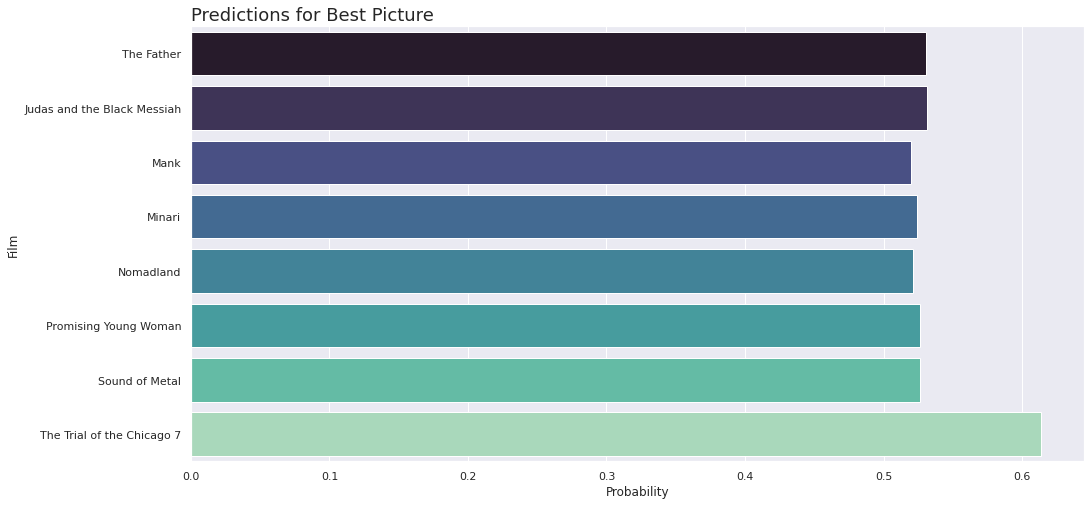

In [39]:
f=plt.figure(figsize=(16,8))
sb.barplot(data = df_from_prediction(nom_bestpicture, bestpicture), y='Film', x='Probability', palette='mako')
plt.title("Predictions for Best Picture", loc='left',fontsize=18)
## comment out after using
#f.savefig('./images/adaboost_best_picture.png',bbox_inches='tight',dpi=600)

Text(0.0, 1.0, 'Predictions for Best Original Screenplay')

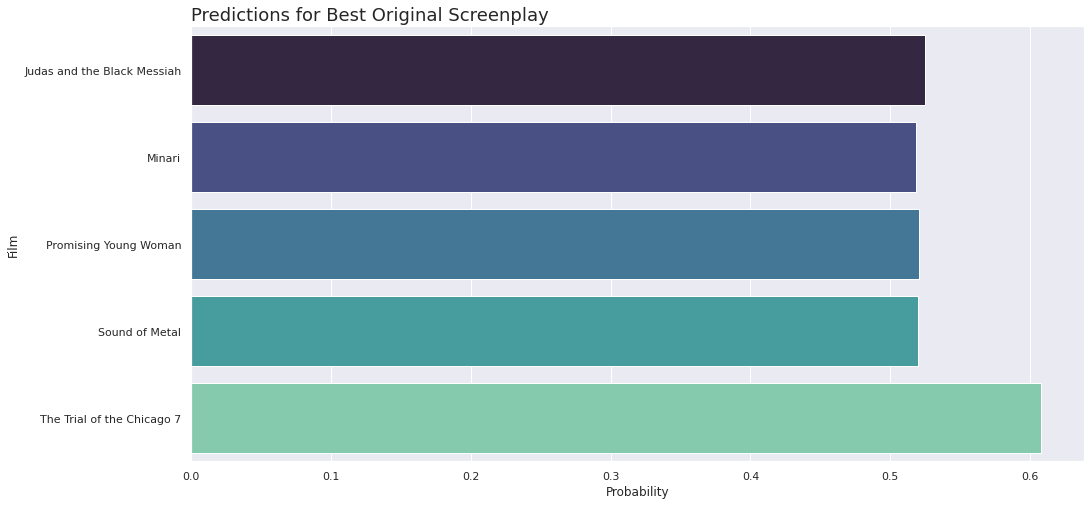

In [44]:
f=plt.figure(figsize=(16,8))
sb.barplot(data = df_from_prediction(nom_bestorg, bestorg), y='Film', x='Probability', palette='mako')
plt.title("Predictions for Best Original Screenplay", loc='left',fontsize=18)
## comment out after using
#f.savefig('./images/adaboost_best_org.png',bbox_inches='tight',dpi=600)